In [1]:
!pip install datasets pandas scikit-learn torch transformers tqdm fugashi unidic-lite accelerate japanize-matplotlib seaborn peft trl bitsandbytes

  Using cached transformers-4.49.0-py3-none-any.whl.metadata (44 kB)
  Using cached unidic-lite-1.0.8.tar.gz (47.4 MB)
  Preparing metadata (setup.py) ... done
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.7/671.7 kB 20.5 MB/s eta 0:00:00
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
anceled
ERROR: Operation cancelled by user


### Fine-tuning flow

1. Prepare local dataset or load public dataset
2. Load model and tokenizer
3. Train a model

# Library

In [1]:
from typing import Dict
import os
import tarfile
import warnings
import sys

import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import (
    AutoModelForCausalLM, AutoTokenizer, AutoModel, EvalPrediction, TrainingArguments,
    Trainer, EarlyStoppingCallback, BitsAndBytesConfig
)
from transformers.modeling_outputs import ModelOutput
from peft import LoraConfig, get_peft_model

sys.path.append("../src")

from utils.utils import Timer

warnings.filterwarnings("ignore")

data_path = "../data"
training_timer = Timer()
inference_timer = Timer()

/opt/conda/envs/llm_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

## Load public dataset

In [ ]:
# raw_datasets = load_dataset("glue", "mrpc")

# def tokenize_function(example):
#     return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

# tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# trainer = Trainer(
#     model,
#     training_args,
#     train_dataset=tokenized_datasets["train"],
#     eval_dataset=tokenized_datasets["validation"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
# )

## Livedoor news content

### data download

- Src: https://zenn.dev/robes/articles/c2c65d9aef7562
- Dataset: https://www.rondhuit.com/download/ldcc-20140209.tar.gz

In [7]:
!mkdir {data_path}/ldcc_data {data_path}/ldcc_data/text {data_path}/ldcc_data/content

# ファイルパスを指定する
tar_file_path = f"{data_path}/uploaded/ldcc-20140209.tar.gz"
extract_folder = f"{data_path}/ldcc_data/"

!tar -xf {tar_file_path} -C {extract_folder}
!ls {extract_folder}text

mkdir: cannot create directory ‘/home/jupyter/experiment/llm_finetuning/data/ldcc_data’: File exists
mkdir: cannot create directory ‘/home/jupyter/experiment/llm_finetuning/data/ldcc_data/text’: File exists
CHANGES.txt	it-life-hack	movie-enter  sports-watch
README.txt	kaden-channel	peachy	     topic-news
dokujo-tsushin	livedoor-homme	smax


### data formatter

In [5]:
def read_articles_from_directory(directory_path):
    #ディレクトリーの中から記事のテキストファイルのパスをリストとして読み込む
    files = [f for f in os.listdir(directory_path) if f not in ["LICENSE.txt"]]
    
    articles = []
    for file in files:
        #記事を一つずつ読み込み、url,date,bodyに分け、辞書を作る
        with open(os.path.join(directory_path, file), 
		"r", encoding="utf-8") as f:
            lines = f.readlines()
            articles.append({
                "url": lines[0].strip(),
                "date": lines[1].strip(),
                "body": ''.join(lines[2:]).strip()
            })
    
    return articles

In [8]:
# 各記事のディレクトリーを取得する
directories = [d for d in os.listdir(extract_folder + "text/") 
	if d not in ["CHANGES.txt", "README.txt"]]

# カテゴリーごとのCSVファイルを作る
csv_file_paths = {}
for directory in directories:
    # Read articles from the category directory
    articles = read_articles_from_directory(extract_folder + "text/" + directory)
    df = pd.DataFrame(articles)

    # Save to CSV
    csv_path = f"{data_path}/ldcc_data/content/{directory}.csv"
    df.to_csv(csv_path, index=False)
    csv_file_paths[directory] = csv_path

print(csv_file_paths)

{'kaden-channel': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/kaden-channel.csv', 'dokujo-tsushin': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/dokujo-tsushin.csv', 'it-life-hack': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/it-life-hack.csv', 'livedoor-homme': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/livedoor-homme.csv', 'movie-enter': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/movie-enter.csv', 'sports-watch': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/sports-watch.csv', 'topic-news': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/topic-news.csv', 'smax': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/smax.csv', 'peachy': '/home/jupyter/experiment/llm_finetuning/data/ldcc_data/content/peachy.csv'}


In [10]:
new_data = []

for directory in directories:
    data_csv = pd.read_csv(f"{data_path}/ldcc_data/content/{directory}.csv")
    for id, row in data_csv.iterrows():
        title = row["body"].split("\n")[0]
        body = "\n".join(row["body"].split("\n")[1:])
        new_data.append([
            directory, title, body
        ])
        
new_data = pd.DataFrame(new_data, columns = ["category", "title", "body"])

new_data.to_pickle(f"{data_path}/ldcc_data/livedoor_data.pkl")

# Data Loading

## Livedoor news content

In [2]:
df = pd.read_pickle(f"{data_path}/ldcc_data/livedoor_data.pkl")
# カテゴリーのID列を付与しておく
categories = df['category'].unique().tolist()
category2id = {cat: categories.index(cat) for cat in categories}
df['category_id'] = df['category'].map(lambda x: category2id[x])

df.sample(3)

,category,title,body,category_id
1420,dokujo-tsushin,素足もスキニーパンツも怖くない!人気ダイエットサロンのノウハウを凝縮した一冊,ようやく春めき始め、春服戦線も本番となりつつある今日この頃。素足になることも増え、冬服で隠し...,1
4687,sports-watch,【Sports Watch】安藤美姫に災難再び、変顔写真に批判の声,モスクワで開催されたフィギュアスケートのGPシリーズ第5戦「ロシア杯」では、安藤美姫がショー...,5
5703,smax,海外向けSIMフリーモデル「HTC One V T320e」を使ってみよう！ソフトバンクの「...,およそ2年で何が変わった？Desireとの比較 \n\nローエンドからミドルエンドユーザーを...,7


# Data Preprocessing

In [3]:
train_df, eval_df = train_test_split(df, train_size=0.7)
eval_df, test_df = train_test_split(eval_df, train_size=0.5)
print('train size', train_df.shape)
print('eval size', eval_df.shape)
print('test size', test_df.shape)
# train size (5156, 4)
# eval size (1105, 4)
# test size (1106, 4)

train size (5156, 4)
eval size (1105, 4)
test size (1106, 4)


# Dataset class

In [15]:
class LivedoorDataset(Dataset):
    def __init__(self, df):
        self.features = [
            {
                'title': row.title,
                'category_id': row.category_id
            } for row in tqdm(df.itertuples(), total=df.shape[0])
        ]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

train_dataset = LivedoorDataset(train_df)
eval_dataset = LivedoorDataset(eval_df)
test_dataset = LivedoorDataset(test_df)

100%|██████████| 1106/1106 [00:00<00:00, 507927.32it/s]


In [16]:
train_dataset[0]

{'title': '【Sports Watch】浅田真央の逆転優勝、荒川キッパリ“可能です”', 'category_id': 7}

# Data collator

## Livedoor news content

In [6]:
model_name = 'deepseek-ai/deepseek-llm-7b-base'

# model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# model_name = 'facebook/opt-125m'
# model_name = 'microsoft/phi-2'
# model_name = 'meta-llama/Llama-3.1-8B-Instruct'
# model_name = 'lmsys/vicuna-7b-v1.5'
# model_name = 'mistralai/Mistral-7B-v0.1'
# model_name = 'google/gemma-2-2b-it'
# model_name = 'Qwen/Qwen2.5-VL-7B-Instruct'

output_path = "/home/jupyter/llm/finetuning/output/simple_classification"
target_model = model_name.replace("/", "_")

os.makedirs(f"{output_path}/{target_model}", exist_ok=True)

print(target_model)

if target_model in ['deepseek-ai/deepseek-llm-7b-base']:
    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
    # モデルをロード（FP32を使用してFP8を無効化）
    pretrained_model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")
    lora_config = LoraConfig(
        r=8, lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05, bias="none"
    )

    pretrained_model = get_peft_model(pretrained_model, lora_config)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
else:
    pretrained_model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

deepseek-ai_deepseek-llm-7b-base


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


In [5]:
class DataCollator():
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __call__(self, examples):
        examples = {
            'title': list(map(lambda x: x['title'], examples)),
            'category_id': list(map(lambda x: x['category_id'], examples))
        }
        
        encodings = self.tokenizer(examples['title'],
                                   padding=True,
                                   truncation=True,
                                   max_length=self.max_length,
                                   return_tensors='pt')
        encodings['category_id'] = torch.tensor(examples['category_id'])
        return encodings

In [22]:
data_collator = DataCollator(tokenizer)

In [23]:
loader = DataLoader(train_dataset, collate_fn=data_collator, batch_size=8, shuffle=True)
batch = next(iter(loader))
for k,v in batch.items():
    print(k, v.shape)
# input_ids torch.Size([8, 42])
# token_type_ids torch.Size([8, 42])
# attention_mask torch.Size([8, 42])
# category_id torch.Size([8])

print(batch)
# {'input_ids': tensor([[    2,  8485, 10731,     6, 14484, 28687, 17658, 14239, 17298,  5191,
#            231,     7,   147, 29012,  4955,    11,  2143,   679,   908,    19,
#            159,    37, 11780,   580,  1484,     3,     0,     0,     0,     0,・・・
# 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,・・・
# 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ・・・
# 'category_id': tensor([4, 4, 6, 1, 3, 7, 3, 6])}

input_ids torch.Size([8, 79])
attention_mask torch.Size([8, 79])
category_id torch.Size([8])
{'input_ids': tensor([[100000,   7217,    219,  60145,  90670,   9156,    228,  90670,   9156,
            228,    537,   7217,    113,   7217,    218,   7217,     96,   7217,
            224,  46891,   2214,    118,   1205,   7217,    241,   9156,    217,
           2160,   1404,  48419,  51300,   7217,    219,  48419,   9156,    218,
           7217,    236,   8129,   2214,    118,   1205,  45223,   9156,    214,
           7217,    215,  46891,   8156, 100001, 100001, 100001, 100001, 100001,
         100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
         100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
         100001, 100001, 100001, 100001, 100001, 100001, 100001],
        [100000,  17421,    537,  63907,  65398,   9156,     99,   8550,    218,
          50145,  52462,  83667,  69765,    116,   9156,    113,  79366,    228,
          50145, 

# Modeling

In [10]:
class Bert_Net(nn.Module):
    def __init__(self, pretrained_model, num_categories, loss_function=None):
        super().__init__()
        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size
        self.linear = nn.Linear(self.hidden_size, num_categories)
        self.loss_function = loss_function
    
    def forward(self,
                input_ids,
                attention_mask=None,
                position_ids=None,
                token_type_ids=None,
                output_attentions=False,
                output_hidden_states=False,
                category_id=None):
        
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            position_ids=position_ids,
                            token_type_ids=token_type_ids,
                            output_attentions=output_attentions,
                            output_hidden_states=output_hidden_states)
        
        state = outputs.last_hidden_state[:, 0, :]
        state = self.linear(state)
        
        loss=None
        if category_id is not None and self.loss_function is not None:
            loss = self.loss_function(state, category_id)
        
        attentions=None
        if output_attentions:
            attentions=outputs.attentions
        
        hidden_states=None
        if output_hidden_states:
            hidden_states=outputs.hidden_states
        
        return ModelOutput(
            logits=state,
            loss=loss,
            last_hidden_state=outputs.last_hidden_state,
            attentions=attentions,
            hidden_states=hidden_states
        )
    
class OPT_Net(nn.Module):
    def __init__(self, pretrained_model, num_categories, loss_function=None):
        super().__init__()
        self.bert = pretrained_model
        self.hidden_size = self.bert.config.hidden_size
        self.linear = nn.Linear(self.hidden_size, num_categories)
        self.loss_function = loss_function

    def forward(self,
                input_ids,
                attention_mask=None,
                position_ids=None,
                token_type_ids=None,
                output_attentions=False,
                output_hidden_states=False,
                category_id=None):
        
        # Check if the model supports `token_type_ids`
        if "token_type_ids" in self.bert.forward.__code__.co_varnames:
            outputs = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                position_ids=position_ids,
                                token_type_ids=token_type_ids,
                                output_attentions=output_attentions,
                                output_hidden_states=output_hidden_states)
        else:
            outputs = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                position_ids=position_ids,
                                output_attentions=output_attentions,
                                output_hidden_states=output_hidden_states)
        
        # Extract the CLS token representation
        state = outputs.last_hidden_state[:, 0, :]
        logits = self.linear(state)
        
        # Compute loss if `category_id` and `loss_function` are provided
        loss = None
        if category_id is not None and self.loss_function is not None:
            loss = self.loss_function(logits, category_id)
        
        # Extract attentions and hidden states if requested
        attentions = outputs.attentions if output_attentions else None
        hidden_states = outputs.hidden_states if output_hidden_states else None
        
        # Return a ModelOutput object
        return ModelOutput(
            logits=logits,
            loss=loss,
            last_hidden_state=outputs.last_hidden_state,
            attentions=attentions,
            hidden_states=hidden_states
        )

In [11]:
loss_fct = nn.CrossEntropyLoss()
if target_model in [
    "facebook_opt-125m",
]:
    net = OPT_Net(pretrained_model, len(categories), loss_fct)
elif target_model in [
    "cl-tohoku_bert-base-japanese-whole-word-masking", "deepseek-ai_deepseek-llm-7b-base"
]:
    net = Bert_Net(pretrained_model, len(categories), loss_fct)

# Custom

## compute_metrics

In [12]:
def custom_compute_metrics(res: EvalPrediction) -> Dict:
    # res.predictions, res.label_idsはnumpyのarray
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

## TrainingArguments

In [13]:
if target_model in ['deepseek-ai/deepseek-llm-7b-base']:
        training_args = TrainingArguments(
        output_dir=f'{output_path}/{target_model}',
        evaluation_strategy="epoch",
        learning_rate=3e-4,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=8,
        num_train_epochs=0.5,
        weight_decay=0.01,
        save_strategy="epoch",
        # logging_dir="./logs",
        # logging_steps=50,
        fp16=True,
    )
    
else:
    training_args = TrainingArguments(
        output_dir=f'{output_path}/{target_model}',
        save_safetensors=False,
        eval_strategy='epoch',
        logging_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=1,
        label_names=['category_id'],
        lr_scheduler_type='constant',
        metric_for_best_model='f1',
        load_best_model_at_end=True,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        num_train_epochs=20,
        remove_unused_columns=False,
        report_to='none'
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Training

In [14]:
with training_timer:
    trainer = Trainer(
        model=net,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=custom_compute_metrics,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train(ignore_keys_for_eval=['last_hidden_state', 'hidden_states', 'attentions'])
    
print(training_timer.duration)

17.963[s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 256.25 MiB is free. Including non-PyTorch memory, this process has 39.12 GiB memory in use. Of the allocated memory 38.59 GiB is allocated by PyTorch, and 44.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## restart from checkpoint

In [ ]:
# trainer.train(ignore_keys_for_eval=['last_hidden_state', 'hidden_states', 'attentions'],
#               resume_from_checkpoint=True)

# Save model

In [32]:
trainer.save_state()
trainer.save_model()

# Predict test data

2.787[s]
2.786808729171753
                precision    recall  f1-score   support

 kaden-channel       1.00      0.93      0.96       125
livedoor-homme       0.77      0.73      0.75        74
    topic-news       0.91      0.90      0.91       117
        peachy       0.81      0.76      0.79       113
          smax       0.94      0.97      0.95       130
dokujo-tsushin       0.90      0.83      0.86       142
  it-life-hack       0.85      0.92      0.88       126
  sports-watch       0.93      0.95      0.94       144
   movie-enter       0.83      0.92      0.87       135

      accuracy                           0.89      1106
     macro avg       0.88      0.88      0.88      1106
  weighted avg       0.89      0.89      0.89      1106

Classification report saved to /home/jupyter/llm/finetuning/output/simple_classification
Confusion matrix saved to /home/jupyter/llm/finetuning/output/simple_classification/cl-tohoku_bert-base-japanese-whole-word-masking/confusion_matrix.png


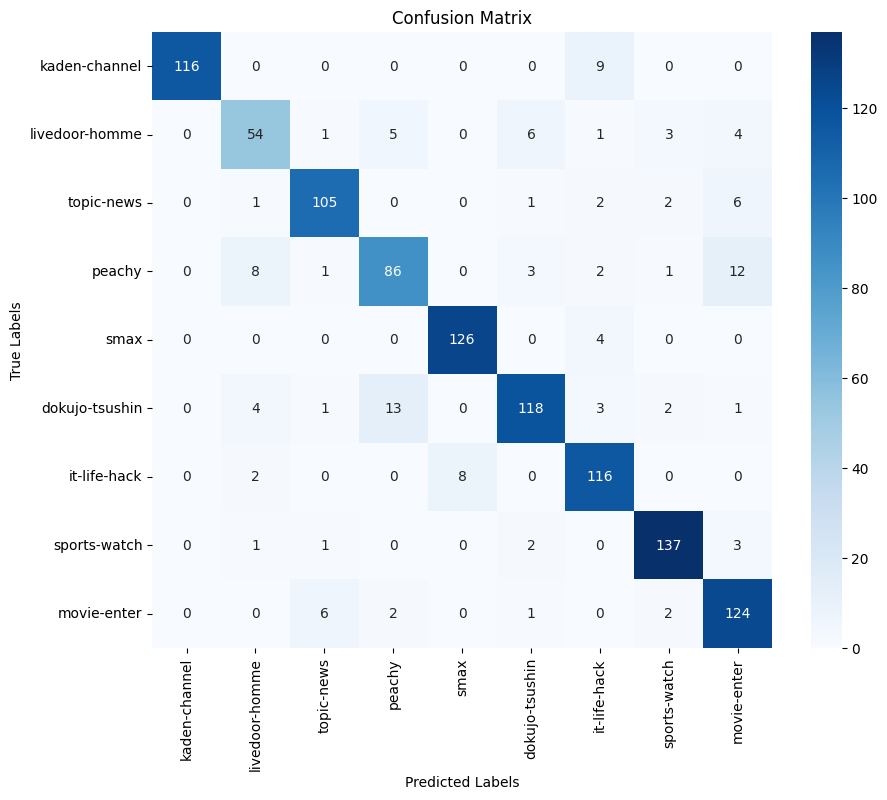

In [34]:
with inference_timer:
    pred_result = trainer.predict(test_dataset, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])
print(inference_timer.duration)
test_df['predict'] = pred_result.predictions.argmax(axis=1).tolist()

report = classification_report(test_df['category_id'], test_df['predict'], target_names=categories)
print(report)

with open(f'{output_path}/{target_model}/classification_report.txt', "w") as f:
    f.write(report)

print(f"Classification report saved to {output_path}")

# 混同行列を生成
conf_matrix = confusion_matrix(test_df['category_id'], test_df['predict'])

# 混同行列を可視化
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# 混同行列を画像として保存
conf_matrix_path = f'{output_path}/{target_model}/confusion_matrix.png'
plt.savefig(conf_matrix_path)
print(f"Confusion matrix saved to {conf_matrix_path}")

# 表示
plt.show()

In [35]:
import json

duration_time_dict = {
    "training_time": training_timer.duration,
    "inference_time": inference_timer.duration
}

# JSON形式で保存
with open(f'{output_path}/{target_model}/duration_time.json', "w") as file:
    json.dump(duration_time_dict, file, indent=4)

# Large Language Model

In [1]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

/opt/conda/envs/llm_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = 'deepseek-ai/deepseek-llm-7b-base'

# model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# model_name = 'facebook/opt-125m'
# model_name = 'microsoft/phi-2'
# model_name = 'meta-llama/Llama-3.1-8B-Instruct'
# model_name = 'lmsys/vicuna-7b-v1.5'
# model_name = 'mistralai/Mistral-7B-v0.1'
# model_name = 'google/gemma-2-2b-it'
# model_name = 'Qwen/Qwen2.5-VL-7B-Instruct'

output_path = "/home/jupyter/llm/finetuning/output/simple_classification"
target_model = model_name.replace("/", "_")

os.makedirs(f"{output_path}/{target_model}", exist_ok=True)

print(target_model)

model_name = 'deepseek-ai/deepseek-llm-7b-base'

compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)
pretrained_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map={"": 0}
)
pretrained_model.config.use_cache = False
pretrained_model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

deepseek-ai_deepseek-llm-7b-base


Loading checkpoint shards: 100%|██████████| 2/2 [01:07<00:00, 33.77s/it]


In [18]:
def custom_compute_metrics(res: EvalPrediction) -> Dict:
    # res.predictions, res.label_idsはnumpyのarray
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

training_params = TrainingArguments(
    output_dir=f'{output_path}/{target_model}',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [21]:
data_collator[0]

TypeError: 'DataCollator' object is not subscriptable

In [26]:
trainer = SFTTrainer(
    model=pretrained_model,
    data_collator=data_collator,
    compute_metrics=custom_compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_params,
    tokenizer=tokenizer,
    args=training_params,
)

AttributeError: 'LivedoorDataset' object has no attribute 'column_names'

In [ ]:
    trainer = Trainer(
        model=net,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=custom_compute_metrics,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

In [1]:
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer, EvalPrediction
# from peft import LoraConfig, get_peft_model
# from datasets import Dataset
# from sklearn.model_selection import train_test_split
# import pandas as pd
# from typing import Dict
# import os
# import tarfile
# import warnings
# import sys

# import pandas as pd
# from tqdm import tqdm

# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score

# from datasets import load_dataset
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# from transformers import (
#     AutoModelForCausalLM, AutoTokenizer, AutoModel, EvalPrediction, TrainingArguments,
#     Trainer, EarlyStoppingCallback, BitsAndBytesConfig
# )
# from transformers.modeling_outputs import ModelOutput
# from peft import LoraConfig, get_peft_model

# sys.path.append("../src")

# from utils.utils import Timer

# warnings.filterwarnings("ignore")

# data_path = "../data"
# training_timer = Timer()
# inference_timer = Timer()

# # メトリクスの定義
# def custom_compute_metrics(res: EvalPrediction) -> Dict:
#     # res.predictions, res.label_idsはnumpyのarray
#     pred = res.predictions.argmax(axis=1)
#     target = res.label_ids
#     precision = precision_score(target, pred, average='macro')
#     recall = recall_score(target, pred, average='macro')
#     f1 = f1_score(target, pred, average='macro')
#     accuracy = accuracy_score(target, pred) # 追加
#     return {
#         'precision': precision,
#         'recall': recall,
#         'f1': f1,
#         'accuracy': accuracy # 追加
#     }

# # モデルとトークナイザーの設定
# model_name = 'deepseek-ai/deepseek-llm-7b-base'

# output_path = "/home/jupyter/llm/finetuning/output/simple_classification"
# target_model = model_name.replace("/", "_")

# os.makedirs(f"{output_path}/{target_model}", exist_ok=True)

# print(target_model)

# # 量子化設定
# from transformers import BitsAndBytesConfig

# quant_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.float16,
#     bnb_4bit_use_double_quant=False,
# )

# # モデルのロード
# pretrained_model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     quantization_config=quant_config,
#     device_map={"": 0}
# )
# pretrained_model.config.use_cache = False
# pretrained_model.config.pretraining_tp = 1

# # トークナイザーのロード
# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.padding_side = "right"

# # LoRA設定
# peft_params = LoraConfig(
#     lora_alpha=16,
#     lora_dropout=0.1,
#     r=64,
#     bias="none",
#     task_type="CAUSAL_LM",
# )
# model = get_peft_model(pretrained_model, peft_params)

# # データセットの準備
# df = pd.read_pickle(f"{data_path}/ldcc_data/livedoor_data.pkl")
# # カテゴリーのID列を付与しておく
# categories = df['category'].unique().tolist()
# category2id = {cat: categories.index(cat) for cat in categories}
# df['category_id'] = df['category'].map(lambda x: category2id[x])

# train_df, eval_df = train_test_split(df, train_size=0.7)

# # データセット
# class LivedoorDataset(Dataset):
#     def __init__(self, df, tokenizer, max_length=512):
#         self.features = df['title'].tolist()
#         self.labels = df['category_id'].tolist()
#         self.tokenizer = tokenizer
#         self.max_length = max_length
    
#     def __len__(self):
#         return len(self.features)
    
#     def __getitem__(self, idx):
#         text = self.features[idx]
#         label = self.labels[idx]
        
#         encodings = self.tokenizer(text,
#                                    padding='max_length',
#                                    truncation=True,
#                                    max_length=self.max_length,
#                                    return_tensors='pt')
        
#         return {
#             'input_ids': encodings['input_ids'].squeeze(),
#             'attention_mask': encodings['attention_mask'].squeeze(),
#             'labels': label  # テンソルに変換しない
#         }

# train_dataset = LivedoorDataset(train_df, tokenizer, max_length=128)
# eval_dataset = LivedoorDataset(eval_df, tokenizer, max_length=128)

# # データコレクタ
# class DataCollator():
#     def __init__(self, tokenizer, max_length=512):
#         self.tokenizer = tokenizer
#         self.max_length = max_length
    
#     def __call__(self, examples):
#         input_ids = [example['input_ids'] for example in examples]
#         attention_masks = [example['attention_mask'] for example in examples]
#         labels = [example['labels'] for example in examples]
        
#         # パディングを行うために、input_idsをリストからテンソルに変換
#         input_ids = torch.nn.utils.rnn.pad_sequence(
#             input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
#         )
#         attention_masks = torch.nn.utils.rnn.pad_sequence(
#             attention_masks, batch_first=True, padding_value=0
#         )
        
#         labels = torch.tensor(labels)
        
#         return {
#             'input_ids': input_ids,
#             'attention_mask': attention_masks,
#             'labels': labels
#         }

# data_collator = DataCollator(tokenizer=tokenizer, max_length=128)

# # トレーニング設定
# training_args = TrainingArguments(
#     output_dir=f'{output_path}/{target_model}',
#     evaluation_strategy="steps",
#     save_strategy="steps",
#     logging_dir=f'{output_path}/{target_model}/logs',
#     logging_steps=100,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=3,
#     learning_rate=2e-4,
#     weight_decay=0.01,
#     save_total_limit=2,
#     fp16=True,
#     remove_unused_columns=False,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy"
# )

# # トレーナーの設定
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     data_collator=data_collator,  # 追加
#     compute_metrics=custom_compute_metrics
# )

# # トレーニング実行
# with training_timer:
#     trainer.train()

# print(f"Training time: {training_timer.get_elapsed_time()}")


/opt/conda/envs/llm_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


deepseek-ai_deepseek-llm-7b-base


Loading checkpoint shards: 100%|██████████| 2/2 [00:21<00:00, 10.69s/it]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


1.524[s]


ValueError: Expected input batch_size (1024) to match target batch_size (8).

In [1]:
from typing import Dict
import sys
import warnings
import os

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, Trainer, TrainingArguments, EvalPrediction, DataCollatorForLanguageModeling
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

sys.path.append("../src")

from utils.utils import Timer

warnings.filterwarnings("ignore")

data_path = "../data"
training_timer = Timer()
inference_timer = Timer()

# 基本パラメータ
model_name = "deepseek-ai/deepseek-llm-7b-base"

output_path = "../output/simple_classification"
target_model = model_name.replace("/", "_")
peft_name = f'{output_path}/{target_model}/peft'
output_dir = f'{output_path}/{target_model}/results'

os.makedirs(f"{output_path}/{target_model}", exist_ok=True)

# トレーニング用パラメータ
eval_steps = 100
save_steps = 200
logging_steps = 20
epochs = 10
max_steps = 0 # 0にするとepochsに応じて自動設定

# LoRA用パラメータ
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1

# 他パラメータ
VAL_SET_SIZE = 0.2 # 検証分割比率
CUTOFF_LEN = 512  # コンテキスト長の上限

# データセットの準備
df = pd.read_pickle("../data/ldcc_data/livedoor_data.pkl")
categories = df['category'].unique().tolist()
category2id = {cat: categories.index(cat) for cat in categories}
df['category_id'] = df['category'].map(lambda x: category2id[x])

train_df, eval_df = train_test_split(df, train_size=0.7)
eval_df, test_df = train_test_split(eval_df, train_size=0.5)

# ベースモデル量子化パラ設定
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# ベースモデルの読み込み
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    quantization_config=bnb_config, 
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# PEFT(LoRA)の設定
config = LoraConfig(r=lora_r,
                    lora_alpha=lora_alpha,
                    lora_dropout=lora_dropout,
                    inference_mode=False,
                    task_type=TaskType.CAUSAL_LM,
)
model = get_peft_model(model, config)
model.print_trainable_parameters()  # 学習可能パラメータの確認

def prepare_dataset(df):
    def generate_prompt(row):
        return f"タイトル: {row['title']}\nカテゴリー: {row['category']}"

    def tokenize(example):
        prompt = example["text"]
        result = tokenizer(prompt,
                           truncation=True,
                           max_length=CUTOFF_LEN,
                           padding="max_length",  # 明示的にpadding
        )
        result["labels"] = result["input_ids"].copy()
        return result

    prompts = df.apply(generate_prompt, axis=1).tolist()
    dataset = Dataset.from_dict({"text": prompts})
    return dataset.map(tokenize, remove_columns=dataset.column_names)

train_data = prepare_dataset(train_df)
eval_data = prepare_dataset(eval_df)
test_data = prepare_dataset(test_df)

# データコレータの定義
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, 
    mlm=False
)

/opt/conda/envs/llm_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.89s/it]


trainable params: 31,457,280 || all params: 6,941,822,976 || trainable%: 0.4532


Map: 100%|██████████| 1106/1106 [00:00<00:00, 1536.99 examples/s]


In [6]:
def generate_prompt(row):
    return f"タイトル: {row['title']}\nカテゴリー: {row['category']}"

def tokenize(example):
    prompt = example["text"]
    result = tokenizer(prompt,
                       truncation=True,
                       max_length=CUTOFF_LEN,
                       padding="max_length",  # 明示的にpadding
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [5]:
row = train_df.iloc[0]

In [7]:
generate_prompt(row)

'タイトル: PCカメラとしての使用も可能な小型トイデジカメ「GH-TCAM30P」登場\nカテゴリー: kaden-channel'

In [ ]:
# トレーナーの定義
trainer = Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    args=TrainingArguments(
        num_train_epochs=epochs,  # エポック数を指定
        learning_rate=3e-4,
        logging_strategy="epoch",  # ログをエポック単位で出力
        evaluation_strategy="epoch",  # 評価をエポック単位で実行
        save_strategy="epoch",  # モデル保存をエポック単位で実行
        output_dir=output_dir,
        report_to="none",
        save_total_limit=3,
        push_to_hub=False,
        auto_find_batch_size=True,
        label_names=["labels"],
        torch_compile=True  # torch_function=Trueを追加
    ),
    data_collator=data_collator,  # ここでデータコレータを指定
)

with training_timer:
    model.config.use_cache = False  # 警告を黙らせます
    trainer.train()
    model.config.use_cache = True   # 推論のために再度有効化
    trainer.model.save_pretrained(peft_name)    # LoRAモデルの保存
    
# モデルの保存
model.save_pretrained(f'{output_path}/{target_model}')
tokenizer.save_pretrained(f'{output_path}/{target_model}')

print("Done!")

In [4]:
with inference_timer:
    pred_result = trainer.predict(test_data, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])
print(inference_timer.duration)
#test_df['predict'] = pred_result.predictions.argmax(axis=1).tolist()

0.844[s]


TypeError: Unsupported types (<class 'transformers.cache_utils.DynamicCache'>) passed to `_pad_across_processes`. Only nested list/tuple/dicts of objects that are valid for `is_torch_tensor` should be passed.

In [3]:
with inference_timer:
    pred_result = trainer.predict(test_data, ignore_keys=['loss', 'last_hidden_state', 'hidden_states', 'attentions'])
print(inference_timer.duration)
test_df['predict'] = pred_result.predictions.argmax(axis=1).tolist()

report = classification_report(test_df['category_id'], test_df['predict'], target_names=categories)
print(report)

with open(f'{output_path}/{target_model}/classification_report.txt', "w") as f:
    f.write(report)

print(f"Classification report saved to {output_path}")

# 混同行列を生成
conf_matrix = confusion_matrix(test_df['category_id'], test_df['predict'])

# 混同行列を可視化
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# 混同行列を画像として保存
conf_matrix_path = f'{output_path}/{target_model}/confusion_matrix.png'
plt.savefig(conf_matrix_path)
print(f"Confusion matrix saved to {conf_matrix_path}")

# 表示
plt.show()

0.661[s]


TypeError: Unsupported types (<class 'transformers.cache_utils.DynamicCache'>) passed to `_pad_across_processes`. Only nested list/tuple/dicts of objects that are valid for `is_torch_tensor` should be passed.

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, DataCollatorForLanguageModeling, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
from datasets import load_dataset

# 基本パラメータ
base_model = "cyberagent/open-calm-7b"
dataset = "bbz662bbz/databricks-dolly-15k-ja-gozaru"
peft_name = "test-Ocalm-7b"
output_dir = "test-Ocalm-7b-result"

# トレーニング用パラメータ
eval_steps = 100
save_steps = 200
logging_steps = 20
epochs = 3
max_steps = 150 # 0にするとepochsに応じて自動設定

# LoRA用パラメータ
lora_r = 8
lora_alpha = 16
lora_dropout = 0.1

# 他パラメータ
VAL_SET_SIZE = 0.2 # 検証分割比率
CUTOFF_LEN = 512  # コンテキスト長の上限

# ベースモデル量子化パラ設定
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# ベースモデルの読み込み
model = AutoModelForCausalLM.from_pretrained(
    base_model, 
    quantization_config=bnb_config, 
    device_map="auto"
)
# Rinnaのトークナイザーでは、「use_fast=False」も必要になる
tokenizer = AutoTokenizer.from_pretrained(base_model)

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# PEFT(LoRA)の設定
config = LoraConfig(r=lora_r,
                    lora_alpha=lora_alpha,
                    lora_dropout=lora_dropout,
                    inference_mode=False,
                    task_type=TaskType.CAUSAL_LM,
)
model = get_peft_model(model, config)
model.print_trainable_parameters()  # 学習可能パラメータの確認

# トークナイズ関数
def tokenize(prompt, tokenizer):
    result = tokenizer(prompt,
                       truncation=True,
                       max_length=CUTOFF_LEN,
                       padding=False,
    )
    return {"input_ids": result["input_ids"],
            "attention_mask": result["attention_mask"],
    }

# データセットの準備
data = load_dataset(dataset)

# プロンプトテンプレートの準備
# 回答の最後にベースモデル特有のEOSトークンを挿入
eos_token = tokenizer.decode([tokenizer.eos_token_id])
def generate_prompt(data_point):
    if data_point["input"]:
        result = f"""ユーザー:{data_point["instruction"]}
入力:{data_point["input"]}
システム:{data_point["output"]}{eos_token}"""
    else:
        result = f"""ユーザー:{data_point["instruction"]}
システム:{data_point["output"]}{eos_token}"""

    result = result.replace('\n', '<NL>')   # 改行→<NL>
    return result

# 学習データと検証データの準備
train_val = data["train"].train_test_split(test_size=VAL_SET_SIZE, shuffle=True, seed=42)
train_data = train_val["train"]
val_data = train_val["test"]
train_data = train_data.shuffle().map(lambda x: tokenize(generate_prompt(x), tokenizer))
val_data = val_data.shuffle().map(lambda x: tokenize(generate_prompt(x), tokenizer))

# トレーナーの定義
trainer = Trainer(
    model = model, 
    train_dataset = train_data,
    eval_dataset = val_data,
    args = TrainingArguments(
        num_train_epochs=epochs,
        learning_rate=3e-4,
        logging_steps=logging_steps,
        evaluation_strategy="steps",
        save_strategy="steps",
        max_steps=max_steps,
        eval_steps=eval_steps,
        save_steps=save_steps,
        output_dir=output_dir,
        report_to="none",
        save_total_limit=3,
        push_to_hub=False,
        auto_find_batch_size=True
    ),
    data_collator= DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # 警告を黙らせます
trainer.train()
model.config.use_cache = True   # 推論のために再度有効化
trainer.model.save_pretrained(peft_name)    # LoRAモデルの保存

print("Done!")

/opt/conda/envs/llm_ft/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [01:32<00:00, 46.06s/it]


trainable params: 4,194,304 || all params: 6,876,176,384 || trainable%: 0.0610


Map: 100%|██████████| 3003/3003 [00:03<00:00, 793.62 examples/s]
/opt/conda/envs/llm_ft/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/opt/conda/envs/llm_ft/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between 

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [2]:
from datasets import load_dataset

# データセットの読み込み
dataset_name = "bbz662bbz/databricks-dolly-15k-ja-gozaru"  # 使用しているデータセット名
dataset = load_dataset(dataset_name)

# データセット全体の概要を表示
print(dataset)

# 各分割（例: train）の最初の数行を表示
for split in dataset.keys():
    print(f"=== {split} split ===")
    print(dataset[split].to_pandas().head())  # pandas形式で確認する場合

DatasetDict({
    train: Dataset({
        features: ['category', 'instruction', 'input', 'output', 'index'],
        num_rows: 15015
    })
})
=== train split ===
         category                           instruction  \
0       closed_qa      ヴァージン・オーストラリア航空はいつから運航を開始したのですか？   
1  classification                魚の種類はどっち？イコクエイラクブカとロープ   
2         open_qa                  ラクダはなぜ水なしで長く生きられるのか？   
3         open_qa  アリスの両親には3人の娘がいる：エイミー、ジェシー、そして三女の名前は？   
4       closed_qa                        小森田友明はいつ生まれたの？   

                                               input  \
0  ヴァージン・オーストラリア航空（Virgin Australia Airlines Pty ...   
1                                                      
2                                                      
3                                                      
4  小森田は1981年7月10日、熊本県に生まれる。高校卒業後、2000年にJ1リーグのアビスパ...   

                                              output index  
0  ヴァージン・オーストラリア航空は、2000年8月31日にヴァージン・ブルー航空として、2機の...     0  
1                     

In [5]:
dataset[split].to_pandas().head()

,category,instruction,input,output,index
0,closed_qa,ヴァージン・オーストラリア航空はいつから運航を開始したのですか？,ヴァージン・オーストラリア航空（Virgin Australia Airlines Pty ...,ヴァージン・オーストラリア航空は、2000年8月31日にヴァージン・ブルー航空として、2機の...,0
1,classification,魚の種類はどっち？イコクエイラクブカとロープ,,イコクエイラクブカでござる。,1
2,open_qa,ラクダはなぜ水なしで長く生きられるのか？,,ラクダは、長時間にわたってエネルギーと水分で満たされた状態を保つために、腰の脂肪を利用してい...,2
3,open_qa,アリスの両親には3人の娘がいる：エイミー、ジェシー、そして三女の名前は？,,三女の名前はアリスでござる。,3
4,closed_qa,小森田友明はいつ生まれたの？,小森田は1981年7月10日、熊本県に生まれる。高校卒業後、2000年にJ1リーグのアビスパ...,小森田友明は1981年7月10日に生まれましたでござる。,4


In [4]:
dataset[split].to_pandas().head().values

array([['closed_qa', 'ヴァージン・オーストラリア航空はいつから運航を開始したのですか？',
        'ヴァージン・オーストラリア航空（Virgin Australia Airlines Pty Ltd）はオーストラリアを拠点とするヴァージン・ブランドを冠する最大の船団規模を持つ航空会社です。2000年8月31日に、ヴァージン・ブルー空港として、2機の航空機、1つの空路を運行してサービスを開始しました。2001年9月のアンセット・オーストラリア空港の崩壊後、オーストラリアの国内市場で急速に地位を確立しました。その後はブリスベン、メルボルン、シドニーをハブとして、オーストラリア国内の32都市に直接乗り入れるまでに成長しました。',
        'ヴァージン・オーストラリア航空は、2000年8月31日にヴァージン・ブルー航空として、2機の航空機で単一路線の運航を開始しましたでござる。',
        '0'],
       ['classification', '魚の種類はどっち？イコクエイラクブカとロープ', '', 'イコクエイラクブカでござる。',
        '1'],
       ['open_qa', 'ラクダはなぜ水なしで長く生きられるのか？', '',
        'ラクダは、長時間にわたってエネルギーと水分で満たされた状態を保つために、腰の脂肪を利用していますでござる。', '2'],
       ['open_qa', 'アリスの両親には3人の娘がいる：エイミー、ジェシー、そして三女の名前は？', '',
        '三女の名前はアリスでござる。', '3'],
       ['closed_qa', '小森田友明はいつ生まれたの？',
        '小森田は1981年7月10日、熊本県に生まれる。高校卒業後、2000年にJ1リーグのアビスパ福岡に入団。2001年にMFとしてデビューするも、出番は少なく、2001年シーズン終了後にJ2リーグに降格する。2002年、J2の大分トリニータに移籍。守備的MFとしてレギュラーに定着し、2002年に優勝、2003年に昇格を果たす。2005年まで多くの試合に出場した。2005年9月、J2のモンテディオ山形に移籍。2006年、J2のヴィッセル神戸へ移籍。

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from datasets import Dataset, load_dataset, DatasetDict

model_name = "deepseek-ai/deepseek-llm-7b-base"
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config, device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.07s/it]


In [3]:
df = pd.read_pickle(f"{data_path}/ldcc_data/livedoor_data.pkl")
# カテゴリーのID列を付与しておく
categories = df['category'].unique().tolist()
category2id = {cat: categories.index(cat) for cat in categories}
df['category_id'] = df['category'].map(lambda x: category2id[x])

train_df, eval_df = train_test_split(df, train_size=0.7)
eval_df, test_df = train_test_split(eval_df, train_size=0.5)
print('train size', train_df.shape)
print('eval size', eval_df.shape)
print('test size', test_df.shape)
# train size (5156, 4)
# eval size (1105, 4)
# test size (1106, 4)

train size (5156, 4)
eval size (1105, 4)
test size (1106, 4)


In [4]:
train_data_dict = {
    "text": [row["title"] + "\n" + row["body"] for idx, row in train_df.iterrows()],
    "label": [row["category_id"] for idx, row in train_df.iterrows()],
}
eval_data_dict = {
    "text": [row["title"] + "\n" + row["body"] for idx, row in eval_df.iterrows()],
    "label": [row["category_id"] for idx, row in eval_df.iterrows()],
}
test_data_dict = {
    "text": [row["title"] + "\n" + row["body"] for idx, row in test_df.iterrows()],
    "label": [row["category_id"] for idx, row in test_df.iterrows()],
}

# DatasetDictを作成
dataset = DatasetDict({
    "train": Dataset.from_dict(train_data_dict),
    "eval": Dataset.from_dict(eval_data_dict),
    "test": Dataset.from_dict(test_data_dict)
})

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5156
    })
    eval: Dataset({
        features: ['text', 'label'],
        num_rows: 1105
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1106
    })
})

In [6]:
# トークン化関数
def tokenize_function(example):
    tokens = tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)
    tokens["labels"] = tokens["input_ids"].copy()  # labelsをinput_idsのコピーとして追加
    return tokens

# トークン化を適用
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# 結果を表示
print(tokenized_dataset)

Map: 100%|██████████| 1106/1106 [00:00<00:00, 1292.99 examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5156
    })
    eval: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1105
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1106
    })
})


In [7]:
small_train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(500))
small_test_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(100))

print("Tokenized Sample:")
print(small_train_dataset[0])

Tokenized Sample:
{'text': '「電力使用状況グラフ」にダマされるな【デジ通】\n東日本を中心に、国民の間に「節電」意識は相当に定着したようだ。だが、現在の風潮には「勘違い」や「行き過ぎ」があるのも事実。電力需要は冬にも再度ひっ迫すると言われているだけに、冷静な対応こそ必要だ。\n\n\n■ネオンの消灯は不要！\n荒川区に住む筆者の部屋からは、上野や秋葉原のビルが見える。以前は、夜間に電気店の広告ネオンが明るく見えたものだが、いまや消えたままだ。看板広告が「自粛」されているのである。時間にもよるし、看板の性質にもよるので一概には言えないが、これはほとんど「節電」には効果はない。ネオン看板を使用する時間帯、すなわち夜間の電力には、十分に余裕があるからである。\n\n■安全性を無視してはいけない\n経費節約のために、看板を所有するビルや企業が「節電」するのは自由だが、それでお客が減ったり、広告収入がなくなるのでは、経営にとっては逆効果である。また、夜間の駅・道路などで、いたずらに電気を暗くすると、防犯上の問題も出てくる。社会の存続には必要なコストというものがあり、それを無視した「節電」論議は、本末転倒である。要は、バランスを考えることだ。\n\n■「電力使用状況グラフ」は正しいのか？\nポータルサイトなどには、電力会社が提供する情報に基づいた「電力使用状況グラフ」が表示されている。だが、この数値は正しいのだろうか？\u3000一説では、このグラフの「供給電力」は「底下げ」（底上げの反対）されており、実際の供給可能電力はもっと大きいという。電力会社は、数値の意味するものも含め、正確な情報を提供することが必要なのではないだろうか。むろん、「電気をムダに使え」というのは論外だが。\n\n■蓄電の仕組みを導入すべき\n基本的に、電気は「ためておけない」。電力に余裕のある夜間の看板に目くじらを立てるのは、この点が理解できていないのである。この誤解を解く一つの方法は、社会的に蓄電のシステムを普及させることだ。ネオン看板を使用する店なら、閉店時に充電しておけばよい。「節電をしていない」という非難に対して、「ためた電気を使っているのだから何が悪い」と反論できるし、多数普及すれば、全体の電力受給も効率的になる。\n\nだが、パソコンのバッテリが数時間しかもたないよ

In [8]:
output_path = "../output/simple_classification"
target_model = model_name.replace("/", "_")
peft_name = f'{output_path}/{target_model}/peft'
output_dir = f'{output_path}/{target_model}/results'

os.makedirs(f"{output_path}/{target_model}", exist_ok=True)

In [9]:
lora_config = LoraConfig(
    r=4, lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05, bias="none"
)

model = get_peft_model(model, lora_config)

In [10]:
from transformers import TrainingArguments, Trainer

# メトリクスの定義
def custom_compute_metrics(res: EvalPrediction) -> Dict:
    # res.predictions, res.label_idsはnumpyのarray
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    accuracy = accuracy_score(target, pred) # 追加
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy # 追加
    }

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",  # ステップ単位で評価
    eval_steps=100,               # 100ステップごとに評価
    save_strategy="epoch",        # ステップ単位で保存
    save_steps=200,               # 200ステップごとに保存
    learning_rate=3e-4,
    per_device_train_batch_size=1,  # バッチサイズを増加
    gradient_accumulation_steps=4,  # 勾配蓄積を調整
    num_train_epochs=20,             # エポック数を増加
    weight_decay=0.01,
    logging_dir=f"{output_dir}/logs",
    logging_steps=10,               # ログの頻度を増加
    fp16=True,                      # 半精度浮動小数点を使用
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_test_dataset,
# )

# トレーナーの設定
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    # data_collator=data_collator,
    compute_metrics=custom_compute_metrics,  # 評価指標を設定
    # label_names=["labels"]            # ラベル名を明示的に指定
)

trainer.train()

No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.06 GiB. GPU 0 has a total capacity of 39.38 GiB of which 13.52 GiB is free. Including non-PyTorch memory, this process has 25.85 GiB memory in use. Of the allocated memory 18.87 GiB is allocated by PyTorch, and 6.47 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)